# Different question types

In [1]:
%cd ..

C:\Users\Stefan.Beuchert\Desktop\backup_from_kubectl


In [2]:
# config
number_of_features = 10 # the default value
number_of_samples = 5000 # the default value

source_path_for_data = f'data/Data_Preparation/lime_ns_{number_of_samples}_nf_{number_of_features}_after_frequency_analysis.json'

In [3]:
from src.analyzer import sort_tokens_in_categories, get_frequencie, display_frequencies
from src.ExplanationObjectForQuestionType import ExplanationObjectForQuestionType
from src.get_data import enhance_data_with_question_type

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Stefan.Beuchert\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stefan.Beuchert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# load data
data_df = pd.read_json(source_path_for_data)
data_df['explanation'] = [pd.DataFrame(exp) for exp in data_df['explanation'].tolist()]
data_df.head()

,question,answers,context,document_id,is_impossible,usage,prediction,explanation
37495,Wie viele Amerikaner fühlen sich mehr als eine...,"[{'answer_id': 37854, 'document_id': 41057, 'q...",Race__United_States_Census_\n\n=== „Race“ ===\...,41057,False,test,fast sieben Millionen,position_id lime_token question_or_cont...
36553,Wer wanderte nach North Carolina Anfang des 20...,"[{'answer_id': 36895, 'document_id': 40789, 'q...",North_Carolina\n\n==== Europäische Amerikaner ...,40789,False,test,eine Gruppe orthodoxer Einwanderer aus der Ukr...,position_id lime_token question_or_contex...
36597,Was gehört zum Stadtkirchenverband Hannover?,"[{'answer_id': 36938, 'document_id': 40797, 'q...",Hannover\n\n==== Evangelisch-lutherische Kirch...,40797,False,test,Alle landeskirchlichen evangelischen Kirchenge...,position_id lime_token question...
37392,Wann starb Athanasius der Große?,"[{'answer_id': 37749, 'document_id': 41075, 'q...","Athanasius_der_Große\nGriechische Ikone, Titul...",41075,False,test,2. Mai 373,position_id lime_token question_or_con...
37351,Welche Länder liegen östlich des Irans?,"[{'answer_id': 37706, 'document_id': 41082, 'q...",Iran\n\n=== Antike und Mittelalter ===\nDas he...,41082,False,test,Indien und China,position_id lime_token question_or_conte...


## Prepare Data

In [5]:
data_df = enhance_data_with_question_type(data_df)

In [6]:
if False:
    # split into question types
    def identify_question_type(question):
        question = question.lower()
        if question[-1] == '?': question = question[:-1] # remove '?' from question (if there is one)

        question_type = None

        # check for 'wie viel' as the only w-question that contains two 2 tokens
        if 'wie viel' in question:
            question_type = 'wie viel'

        # if 'wie viel' is identified, no need to check for other question words
        else:
            # split question into tokens
            question_tokens = question.split(' ')

            # turns out that all questions have the question word at the beginning of the question.
            # therefore we only have to look at the first token
            # question_tokens = [question_tokens[0]]

            question_words_list = [
                # https://de.wikipedia.org/wiki/W-Wort
                'wer', 'welche', 'welcher',
                'wem', 'wen', 'welchen', 'welchem',
                'wessen',
                'was', 'welches',
                'warum', 'weshalb', 'weswegen', 'wieso',
                'wie', 'wieweit', #'wie viel'
                'wofür', 'wozu', 'womit', 'wodurch', 'worum', 'worüber', 'wobei', 'wovon', 'woraus',
                'wo', 'wogegen',
                'wohin', 'woher',
                'woran', 'worin', 'worauf', 'worunter', 'wovor', 'wohinter', 'woneben',
                'wann',
                # below words that have been added by looking at the questions that are not covered by the word above
                'wonach', 'inwiefern' 
            ]

            # check for other w-quetions
            for question_word in question_words_list:
                if question_word in question_tokens:
                    if (question_type is not None):
                        #print(f'{question} - has multiple question types')
                        question_type = 'conflict'
                    else:
                        question_type = question_word

        if question_type is None:
            print(f'{question} - has no question type')
            question_type = 'undefined'

        return question_type

    question_list = data_df['question'].tolist()
    question_type_list = [identify_question_type(q) for q in question_list]
    data_df['question_type'] = question_type_list

## Visualize W-Word distribution

   question_type  count
5            was    441
17           wie    249
3           wann    247
6         welche    243
13           wer    188
18      wie viel    154
9        welcher    106
20            wo    102
7        welchem     75
4          warum     73
10       welches     62
8        welchen     57
19         wieso     31
2      undefined     25
22         wofür     19
11           wem     18
0       conflict     16
33          wozu     10
23         woher      9
21       wodurch      8
12           wen      7
24         wohin      6
32         wovon      5
27         woran      4
1      inwiefern      4
15        wessen      4
16      weswegen      2
26        wonach      2
14       weshalb      2
28        woraus      2
30         worum      2
29         worin      1
31       worüber      1
25         womit      1


<AxesSubplot:xlabel='question_type'>

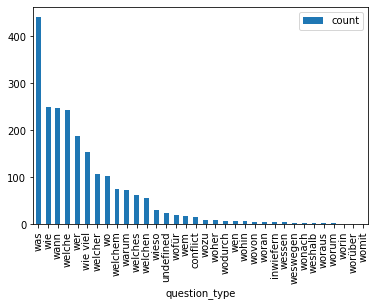

In [7]:
df_for_bar_chart = data_df.groupby(['question_type'])['question_type'].count().reset_index(name='count').sort_values(['count'], ascending=False)
print(df_for_bar_chart)
df_for_bar_chart.plot(kind = 'bar', x = 'question_type')

### Deep dive single question type

was
wie
wann
welche
wer
wie viel
welcher
wo

In [37]:
question_type = 'wo'

In [38]:
single_question_type_df = data_df[data_df['question_type'] == question_type]
single_question_type_df.head(3)

,question,answers,context,document_id,is_impossible,usage,prediction,explanation,question_type
38607,Wo in der Schweiz wird Fronleichnam gefeiert?,"[{'answer_id': 39010, 'document_id': 40720, 'q...",Schweiz\n\n=== Feiertage ===\nIn der Schweiz i...,40720,False,test,nur in den katholischen Kantonen,position_id lime_token question_or_conte...,wo
37367,Wo kann man Rettungshundeprüfungen machen?,"[{'answer_id': 37722, 'document_id': 40682, 'q...",Haushund\n\n==== Sonstiges ====\nEine Verpflic...,40682,False,test,nur in einer zugelassenen Rettungshundestaffel,position_id lime_token quest...,wo
41483,Wo in Hannover stehen die Skulpturen von Niki ...,"[{'answer_id': 43108, 'document_id': 40764, 'q...","Hannover\n\n=== Denkmale, Mahnmale und Straßen...",40764,False,test,am Leibnizufer,position_id lime_token question_or_con...,wo


In [39]:
explanation = ExplanationObjectForQuestionType(question_type, single_question_type_df)

out of 102 data points, 8 have been deleted, because GELECTRA could not find a sufficient answer. 94 data point remaining


In [40]:
print(explanation)


### wo ###
GELECTRA gibt bei ähnlichen Fragen mit 75% Wahrscheinlichkeit eine Antwort zwischen 3 und 17 Worten.
Dabei stellt das Start-Wort in 73 % der Fälle ein ADP oder DET dar.
Für das End-Wort wählt GELECTRA Eigennamen oder Nomen in 93 % der Fälle.

Generell spricht GELECTRA Bindeworten (wenn, falls, während, ...) (+119%) und Ortsangaben (+86%) eine überdurchschnittlich hohe Relevanz bei der Auswahl der Antwort zu.
            


In [41]:
# explanation.visualize()